This is an assignment for my thinkful data science course - "Data Cleaning 2"
Raj Prasad
May 2019


[html version](https://daddyprasad5.github.io/Data_Cleaning_23.html) - with all the code hidden away for a quick read

[jupyter notebook version](https://github.com/daddyprasad5/thinkful/blob/master/Data_Cleaning_3.ipynb) - with all the code exposed in an interactive notebook

In [1]:
#imports
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from scipy.stats.mstats import winsorize



%matplotlib inline

In [2]:
#data load
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

raw_used_df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [3]:
#find the missing values

used_df = raw_used_df.copy()

n = len(used_df)
cols = used_df.columns
num_null = [len(used_df[used_df[col].isnull()]) / n for col in used_df]
pd.DataFrame([cols, num_null]).transpose()

,0,1
0,PRIMARY_KEY,0
1,STATE,0
2,YEAR,0
3,ENROLL,0.176273
4,TOTAL_REVENUE,0.142091
5,FEDERAL_REVENUE,0.142091
6,STATE_REVENUE,0.142091
7,LOCAL_REVENUE,0.142091
8,TOTAL_EXPENDITURE,0.142091
9,INSTRUCTION_EXPENDITURE,0.142091


In [4]:
#fill the missing values

#interpolate missing values, as possible

col_list = ['ENROLL', 'TOTAL_REVENUE',
       'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE',
       'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE',
       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE',
       'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G', 'GRADES_ALL_G', 'AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE',
       'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE']

#add a key and change sort order to the most logical sequence 
# for interpolation: first by state and  then by year
used_df["new_pk"] = used_df.STATE + used_df.YEAR.map(str)
used_df.sort_values(by="new_pk").head()

for col in col_list:
    used_df.loc[:, col].interpolate(inplace=True)
    
#fill with typical proportion of related field for a few remaining NaNs
def fill_with_relative_proportion(df, from_col, to_col): 
    """Fills NaNs in the given dataframe to_col with the median to/from proportion 
    (seen in non-nan columns) multipled by the from_col value"""
    
    not_null_df = used_df.loc[used_df[to_col].notnull()]
    ratios = not_null_df[to_col] / df[from_col] 
    ratio = ratios.median()

    for i, row in used_df.iterrows():
        if np.isnan(row[to_col]): 
            from_value = used_df.get_value(i, from_col)
            used_df.set_value(i, to_col, from_value * ratio)
            
fill_with_relative_proportion(used_df, "AVG_READING_4_SCORE", "AVG_READING_8_SCORE")
fill_with_relative_proportion(used_df, "GRADES_ALL_G", "ENROLL")
fill_with_relative_proportion(used_df, "TOTAL_EXPENDITURE", "OTHER_EXPENDITURE")

In [5]:
#affirm that there are no more NaNs
n = len(used_df)
cols = used_df.columns
num_null = [len(used_df[used_df[col].isnull()]) / n for col in used_df]
pd.DataFrame([cols, num_null]).transpose()

,0,1
0,PRIMARY_KEY,0
1,STATE,0
2,YEAR,0
3,ENROLL,0
4,TOTAL_REVENUE,0
5,FEDERAL_REVENUE,0
6,STATE_REVENUE,0
7,LOCAL_REVENUE,0
8,TOTAL_EXPENDITURE,0
9,INSTRUCTION_EXPENDITURE,0


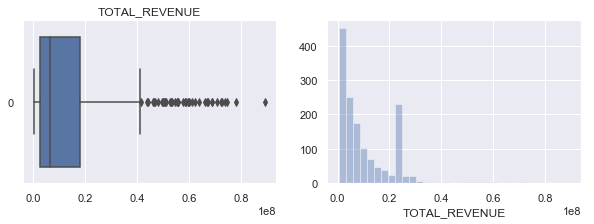

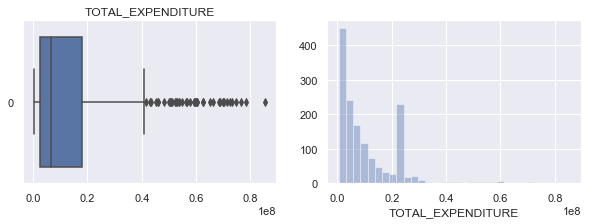

In [6]:
#find outliers visually 
#(whiskers set to 1.5*sd away from quartile range)
#population and $ variables all have lots of outliers on the high side
#test scores have a few outliers on the low side

sns.set()

col_list = ["TOTAL_REVENUE", "TOTAL_EXPENDITURE"]

for col in col_list: 
    plt.figure(figsize=(10, 3))
    plt.subplot(1,2,1)
    sns.boxplot(data=used_df[col], orient="h")
    plt.title(col)
    plt.subplot(1,2,2)
    sns.distplot(used_df[col], kde=False)
    plt.show()

In [7]:
#find outliers statistically (z-scores)

def z_count(df, col, min_z, max_z):
    """
    prints the number of observatins for each of the z scores 
    between the min and max (inclusive)
    """
    
    print("For column {}...".format(str(col)))
    z_scores = zscore(df[col])
    for threshold in range(min_z,max_z):
        num_outliers_up = len(np.where(z_scores > threshold)[0])
        num_outliers_down = len(np.where(z_scores < threshold*-1)[0])
        print("Number of outliers (up-side) is: {} at threshold {}".format(num_outliers_up, threshold))
        print("Number of outliers (down-side) is: {} at threshold {}".format(num_outliers_down, threshold))
        
z_count(used_df, "TOTAL_REVENUE", 1, 5)
z_count(used_df, "TOTAL_EXPENDITURE", 1, 5)

For column TOTAL_REVENUE...
Number of outliers (up-side) is: 322 at threshold 1
Number of outliers (down-side) is: 0 at threshold 1
Number of outliers (up-side) is: 49 at threshold 2
Number of outliers (down-side) is: 0 at threshold 2
Number of outliers (up-side) is: 34 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3
Number of outliers (up-side) is: 18 at threshold 4
Number of outliers (down-side) is: 0 at threshold 4
For column TOTAL_EXPENDITURE...
Number of outliers (up-side) is: 319 at threshold 1
Number of outliers (down-side) is: 0 at threshold 1
Number of outliers (up-side) is: 50 at threshold 2
Number of outliers (down-side) is: 0 at threshold 2
Number of outliers (up-side) is: 36 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3
Number of outliers (up-side) is: 20 at threshold 4
Number of outliers (down-side) is: 0 at threshold 4


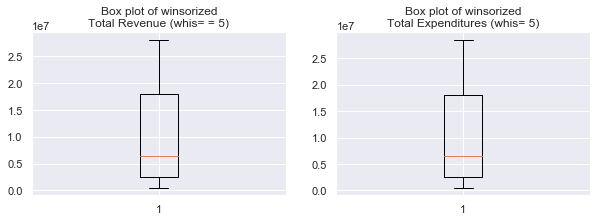

In [8]:
# #2... transform via winsorization (whis = 1.5)
winsorized_tot_rev = winsorize(used_df["TOTAL_REVENUE"], (0, 0.05))
winsorized_tot_exp = winsorize(used_df["TOTAL_EXPENDITURE"], (0, 0.05))

plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.boxplot(winsorized_tot_rev, whis = 5)
plt.title("Box plot of winsorized\nTotal Revenue (whis= = 5)")
plt.subplot(1,2,2)
plt.boxplot(winsorized_tot_exp)
plt.title("Box plot of winsorized\nTotal Expenditures (whis= 5)")
plt.show()

For column log_TOTAL_REVENUE...
Number of outliers (up-side) is: 352 at threshold 1
Number of outliers (down-side) is: 293 at threshold 1
Number of outliers (up-side) is: 15 at threshold 2
Number of outliers (down-side) is: 11 at threshold 2
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3
Number of outliers (up-side) is: 0 at threshold 4
Number of outliers (down-side) is: 0 at threshold 4
For column log_TOTAL_EXPENDITURE...
Number of outliers (up-side) is: 356 at threshold 1
Number of outliers (down-side) is: 302 at threshold 1
Number of outliers (up-side) is: 16 at threshold 2
Number of outliers (down-side) is: 12 at threshold 2
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3
Number of outliers (up-side) is: 0 at threshold 4
Number of outliers (down-side) is: 0 at threshold 4


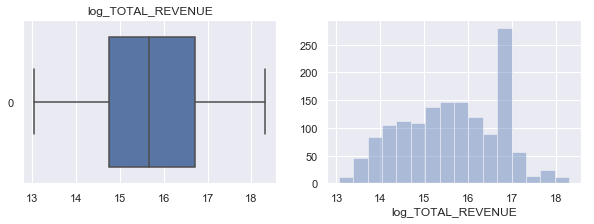

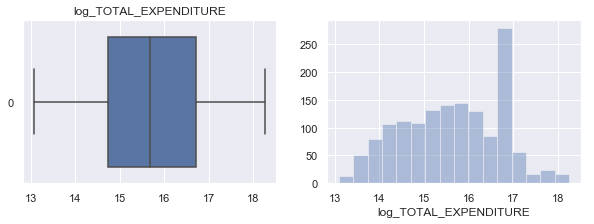

In [9]:
# #2...transform via transformation (log)
used_df["log_TOTAL_REVENUE"] = np.log(used_df["TOTAL_REVENUE"])
used_df["log_TOTAL_EXPENDITURE"] = np.log(used_df["TOTAL_EXPENDITURE"])

z_count(used_df, "log_TOTAL_REVENUE", 1, 5)
z_count(used_df, "log_TOTAL_EXPENDITURE", 1, 5)

col_list = ["log_TOTAL_REVENUE", "log_TOTAL_EXPENDITURE"]

for col in col_list: 
    plt.figure(figsize=(10, 3))
    plt.subplot(1,2,1)
    sns.boxplot(data=used_df[col], orient="h")
    plt.title(col)
    plt.subplot(1,2,2)
    sns.distplot(used_df[col], kde=False)
    plt.show()

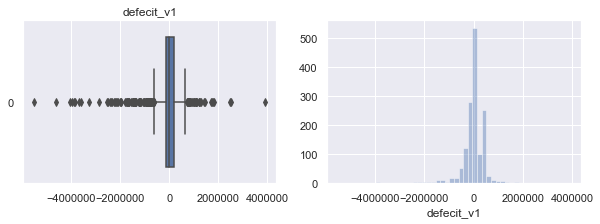

For column defecit_v1...
Number of outliers (up-side) is: 56 at threshold 1
Number of outliers (down-side) is: 97 at threshold 1
Number of outliers (up-side) is: 17 at threshold 2
Number of outliers (down-side) is: 53 at threshold 2
Number of outliers (up-side) is: 7 at threshold 3
Number of outliers (down-side) is: 27 at threshold 3
Number of outliers (up-side) is: 3 at threshold 4
Number of outliers (down-side) is: 15 at threshold 4


In [10]:
# #3...detect budget deficit outliers
used_df["defecit_v1"] = used_df["TOTAL_REVENUE"] - used_df["TOTAL_EXPENDITURE"]

#1..find outliers visually 
# (whiskers set to 1.5*sd away from quartile range)
# population and $ variables all have lots of outliers on the high side
# test scores have a few outliers on the low side

plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
sns.boxplot(data=used_df["defecit_v1"], orient="h")
plt.title("defecit_v1")
plt.subplot(1,2,2)
sns.distplot(used_df["defecit_v1"], kde=False)
plt.show()
    
z_count(used_df, "defecit_v1", 1, 5)

-5487742.0
For column log_defecit_v1...
Number of outliers (up-side) is: 1 at threshold 1
Number of outliers (down-side) is: 21 at threshold 1
Number of outliers (up-side) is: 0 at threshold 2
Number of outliers (down-side) is: 9 at threshold 2
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 3 at threshold 3
Number of outliers (up-side) is: 0 at threshold 4
Number of outliers (down-side) is: 2 at threshold 4


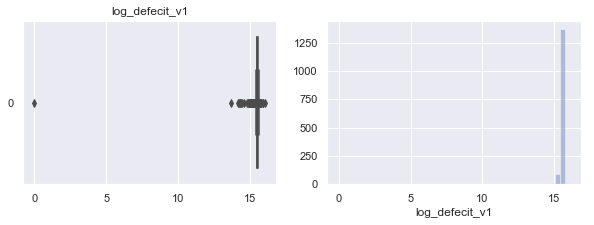

In [11]:
# #3...eliminate budget outliers via transformation (log)
max_def = used_df["defecit_v1"].min()
print(max_def)
used_df["log_defecit_v1"] = np.log(used_df["defecit_v1"] + (-1* max_def) + 1)

z_count(used_df, "log_defecit_v1", 1, 5)

plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
sns.boxplot(data=used_df["log_defecit_v1"], orient="h")
plt.title("log_defecit_v1")
plt.subplot(1,2,2)
sns.distplot(used_df["log_defecit_v1"], kde=False)
plt.show()


In [12]:
used_df[used_df["log_defecit_v1"]<10]

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,new_pk,log_TOTAL_REVENUE,log_TOTAL_EXPENDITURE,defecit_v1,log_defecit_v1
932,2009_TEXAS,TEXAS,2009,4647205.0,48087531.0,4913841.0,19708771.0,23464919.0,53575273.0,23895853.0,...,4480777.0,240.464624,286.685077,218.858272,270.700537,TEXAS2009,17.688533,17.796598,-5487742.0,0.0


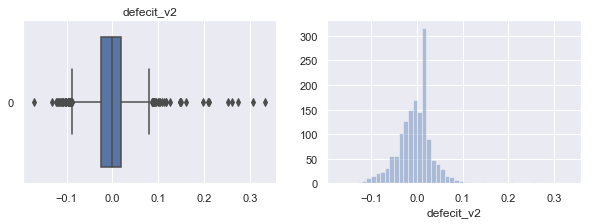

For column defecit_v2...
Number of outliers (up-side) is: 129 at threshold 1
Number of outliers (down-side) is: 194 at threshold 1
Number of outliers (up-side) is: 29 at threshold 2
Number of outliers (down-side) is: 39 at threshold 2
Number of outliers (up-side) is: 13 at threshold 3
Number of outliers (down-side) is: 2 at threshold 3
Number of outliers (up-side) is: 8 at threshold 4
Number of outliers (down-side) is: 1 at threshold 4


In [13]:
# #4...detect budget deficit outliers using outlier-purged inputs for defecit calc
used_df["defecit_v2"] = used_df["log_TOTAL_REVENUE"] - used_df["log_TOTAL_EXPENDITURE"]

#1..find outliers visually 
# (whiskers set to 1.5*sd away from quartile range)
# population and $ variables all have lots of outliers on the high side
# test scores have a few outliers on the low side

plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
sns.boxplot(data=used_df["defecit_v2"], orient="h")
plt.title("defecit_v2")
plt.subplot(1,2,2)
sns.distplot(used_df["defecit_v2"], kde=False)
plt.show()
    
z_count(used_df, "defecit_v2", 1, 5)

-0.17036887720152016
For column log_defecit_v2...
Number of outliers (up-side) is: 132 at threshold 1
Number of outliers (down-side) is: 199 at threshold 1
Number of outliers (up-side) is: 29 at threshold 2
Number of outliers (down-side) is: 47 at threshold 2
Number of outliers (up-side) is: 12 at threshold 3
Number of outliers (down-side) is: 4 at threshold 3
Number of outliers (up-side) is: 8 at threshold 4
Number of outliers (down-side) is: 1 at threshold 4


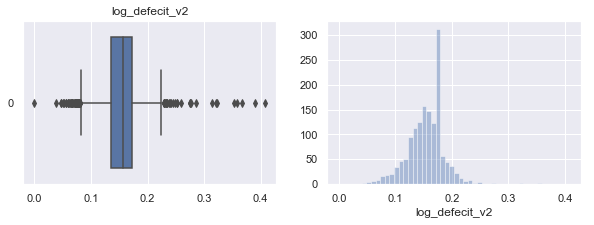

In [14]:
# #4...eliminate budget outliers via transformation (log) - doesn't work! 
# doesn't change the distribution shape at all
max_def = used_df["defecit_v2"].min()
print(max_def)
used_df["log_defecit_v2"] = np.log(used_df["defecit_v2"] + (-1* max_def) + 1)

z_count(used_df, "log_defecit_v2", 1, 5)

plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
sns.boxplot(data=used_df["log_defecit_v2"], orient="h")
plt.title("log_defecit_v2")
plt.subplot(1,2,2)
sns.distplot(used_df["log_defecit_v2"], kde=False)
plt.show()


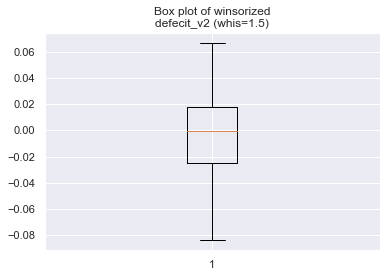

In [15]:
# #4...eliminate budget outliers via transformation (winsorization)

winsorized_defv2 = winsorize(used_df["defecit_v2"], (0.03, 0.03))

plt.boxplot(winsorized_defv2)
plt.title("Box plot of winsorized\ndefecit_v2 (whis=1.5)")
plt.show()

In [16]:
# #5...Compare some basic descriptive statistics of the budget variables you end up 
# with in the third and the fourth questions. Do you see any differences?

comp_df = pd.DataFrame([used_df.log_defecit_v1, winsorized_defv2]).transpose()
comp_df.columns = ["log_post", "log_prior"]
comp_df.describe()

,log_post,log_prior
count,1492.000000,1492.000000
mean,15.495611,-0.003810
std,0.421986,0.034231
min,0.000000,-0.083800
25%,15.492781,-0.024798
50%,15.517930,-0.000261
75%,15.551647,0.017574
max,16.054610,0.066709


they differ all over the place.  hardly comparable really.  

6 - which approach is better.  
I'm not sure why I would pick one over the other.  Will discuss with my mentor.